In [0]:
#@title 기본 제목 텍스트
## import

In [2]:
import tensorflow as tf
from tensorflow import keras

#헬퍼(helper) 라이브러리를 임포트합니다.
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc3


In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


load_data() 함수를 호출하면 네 개의 넘파이 배열이 반환 됩니다.
train_images와 train_labels 배열은 모델 학습에 사용되는 훈련 세트 입니다,
test_images와 test_labels 배열은 모델 테스트에 사용되는 테스트 세트입니다.

이미지는 29X29크기의 넘파이 배열이고 픽셀 값은 0과 255사이입니다.
레이블(label)은 0에서 9까지의 정수 배열입니다.
이 값은 이미지에 있는 옷의 클래스를 나타 냅니다.


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 데이터탐색

---

모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
len(train_labels)

60000

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

## 데이터 전처리
---
네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

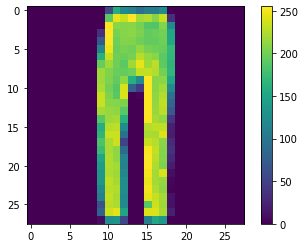

In [16]:
plt.figure()
plt.imshow(train_images[754])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

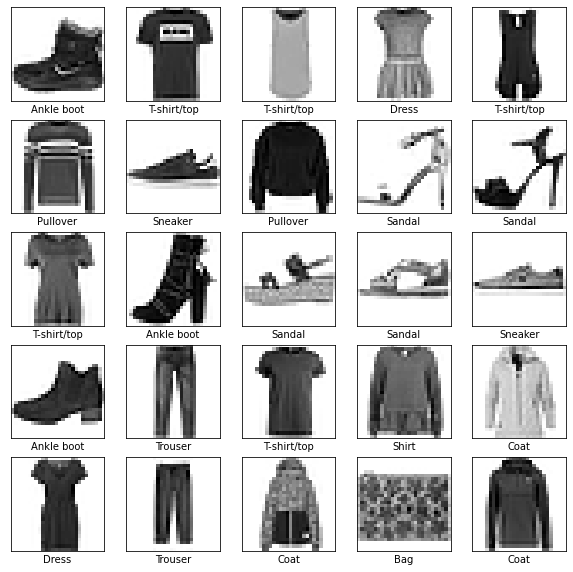

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.
### 층 설정
신경망의 기본 구성 요소는 층(layer)입니다. 층은 주입된 데이터에서 표현을 추출합니다. 아마도 문제를 해결하는데 더 의미있는 표현이 추출될 것입니다.
대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

이 네트워크의 첫 번째 층인 `tf.keras.layers.Flatten`은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 합니다.

픽셀을 펼친 후에는 두 개의 `tf.keras.layers.Dense` 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

### 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:
* *손실 함수*(Loss function)-훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다.
* *옵티마이저*(Optimizer)-데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* *지표*(Metrics)-훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 모델 훈련

신경망 모델을 훈련하는 단계는 다음과 같습니다:
1. 훈련 데이터를 모델에 주입합니다-이 예에서는 `train_images`와 `train_labels` 배열입니다.
1. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
1. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 `test_images` 배열입니다. 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인합니다.

훈련을 시작하기 위해 `model.fit` 메서드를 호출하면 모델이 훈련 데이터를 학습합니다:

In [21]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5046 - accuracy: 0.8223
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3738 - accuracy: 0.8645
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3381 - accuracy: 0.8764
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3115 - accuracy: 0.8852
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2922 - accuracy: 0.8913


## 정확도 평가

그다음 테스트 세트에서 모델의 성능을 비교합니다:

In [22]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

313/313 - 0s - loss: 0.3473 - accuracy: 0.8756

테스트 정확도: 0.8755999803543091


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 ***과대적합(overfitting)*** 때문입니다. 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

## 예측 만들기

훈련된 모델을 사용하여 이미지에 대한 예측을 만들 수 있습니다.

In [23]:
predictions = model.predict(test_images)
predictions[0]

array([2.6552989e-06, 8.7584095e-07, 2.6629218e-06, 9.4245098e-07,
       8.1325356e-07, 5.5756322e-03, 7.2642147e-06, 8.8367060e-02,
       1.7203554e-05, 9.0602487e-01], dtype=float32)

In [24]:
np.argmax(predictions[0])

9

In [25]:
test_labels[0]

9

# 10개의 클래스에 대한 예측

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

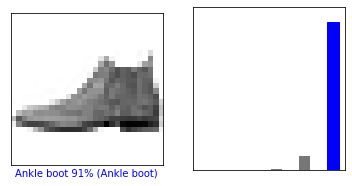

In [27]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

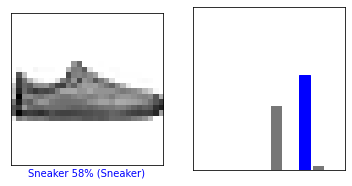

In [28]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

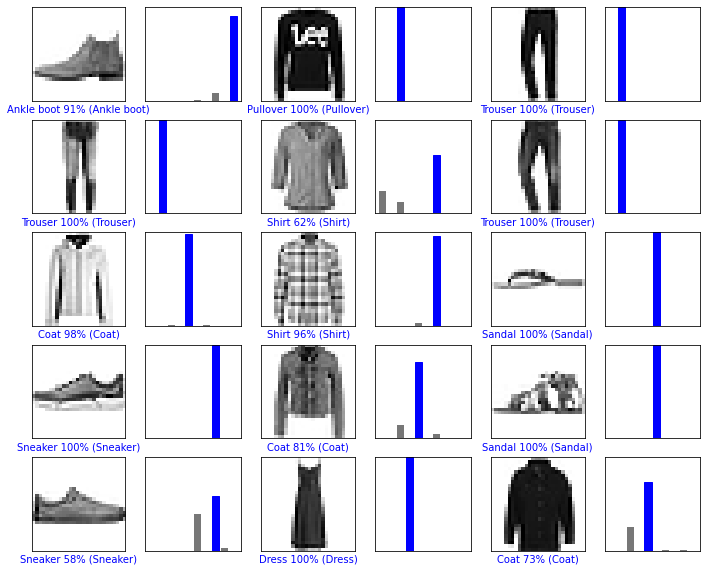

In [29]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [34]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]

print(img.shape)

(28, 28)


In [35]:
# 이미지 하나만 사용할 때도 배치에 추가합니다
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [36]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.6552991e-06 8.7584021e-07 2.6629168e-06 9.4245019e-07 8.1325214e-07
  5.5756303e-03 7.2642288e-06 8.8366978e-02 1.7203591e-05 9.0602499e-01]]


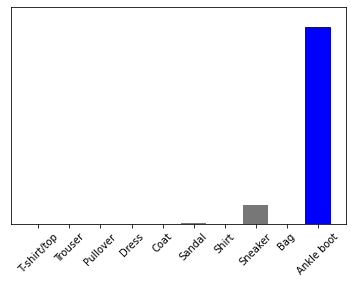

In [37]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [38]:
np.argmax(predictions_single[0])

9